# (a) Splitting the Dataset

Let the first 10 entries of the data set be the validation set, and the last 40 entries be the training set. Concatenate their features into matrices vX and tX, and their responses into vectors vY and tY. Print the shapes of vX, tX, vY and tY.

In [102]:
import numpy as np

data = np.genfromtxt('linear.csv', delimiter=',')

data_x = data[:,1:]
data_y = data[:,0]


val = data[:10,:]
trg = data[10:,:]

vx = val[:,1:]
vy = val[:,0]
tx = trg[:,1:]
ty = trg[:,0]

print(vx.shape, tx.shape, vy.shape, ty.shape)

(10, 4) (40, 4) (10,) (40,)


# (b) Ridge regression with regularization
Write a program in Theano that performs ridge regression by using a regularization
penalty of $\frac{\lambda}{2}||w||^2$ with $\lambda=0.15$. You may use the source codes from Homework 1. Print the resulting value of $w$. Which feature may we assume to be irrelevant?

Loss: 0.15126778264217744


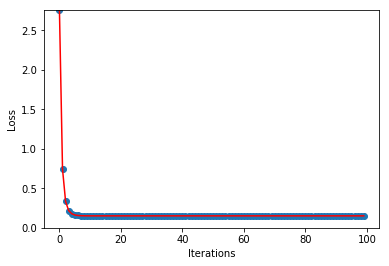

[[-0.53590673]
 [ 1.20293332]
 [ 0.04334568]
 [-1.85492455]]


In [132]:
import theano
import theano.tensor as tensor
import matplotlib.pyplot as plt

feature_dim = tx.shape[1]
num_samples = tx.shape[0]
learn_rate = .5
regularization_param = .15

# init theano variables
x = tensor.matrix(name='x') # 2D feature matrix
y = tensor.vector(name='y') # 1D response vector

# init a updatable shared variable that holds the
# values of parameters we are going to optimize
theta = theano.shared(np.zeros(shape=(feature_dim,1)), name='theta')

# define the training loss and compute the loss gradient
# add regularization term
loss = tensor.sum((tensor.dot(x,theta).T - y)**2)/2/num_samples + (regularization_param/2)*(theta[0,0]**2+theta[1,0]**2+theta[2,0]**2)
grad = tensor.grad(loss, wrt=theta)

# run the training
train_model = theano.function(inputs=[],
			outputs=loss,
			updates=[(theta, theta-learn_rate*grad)],
			givens={x:tx, y:ty})

iters = 100
loss_vals = np.zeros(iters)

for i in range(iters):
    y_loss = train_model()
    if i == 0:
        ymin = y_loss
    loss_vals[i] = y_loss
    
print('Loss: ' + str(y_loss))
    
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.scatter(np.arange(iters),loss_vals)
plt.plot(np.arange(iters),loss_vals,'r')
plt.ylim(0,ymin)
plt.show()

print(theta.get_value())


The intercept or bias term is irrelevant.

# (c) Using BFGS from scipy

Compute the optimal solution using BFGS optimizer from scipy.

Print the resulting value of $w$ for $\lambda=0.15$.

In [133]:
from scipy.optimize import fmin_l_bfgs_b as minimize

# this is the function to be optimized (in this case, minimized)
# function takes arguments (x, *args)
def lossgrad(theta,*args):
    x, y = args[0], args[1]
    loss = np.sum((np.dot(x,theta).T - y)**2)/2/num_samples + (regularization_param/2)*(theta[0,]**2+theta[1,]**2+theta[2,]**2)
    a = np.asarray([theta[0], theta[1], theta[2], 0])
    grad = regularization_param*a + np.dot(np.dot(x.T, x), theta)/num_samples - np.dot(x.T, y)/num_samples
    return loss, grad

#reset theta for this experiment
theta = np.zeros(shape=(feature_dim,1))
opt_theta, loss, messages = minimize(lossgrad, theta, args=(tx,ty))

print(opt_theta)

[-0.53591305  1.20293347  0.04332715 -1.85492236]


# (d) Ridge regression with exact solution
$\hat{\theta} = (n \lambda I + X^T X)^{-1} X^T Y$

In [134]:
def ridge_regression(tx, ty, reg_param):
    n = tx.shape[0] # num samples
    I = np.eye(4)
    I[3,3] = 0
    return np.dot(np.linalg.inv(n*reg_param*I+np.dot(tx.T, tx)), np.dot(tx.T,ty))

print(ridge_regression(tx,ty,regularization_param))

[-0.53590673  1.20293332  0.04334568 -1.85492455]


# (e) Plotting different values of $\lambda$

[-0.57006903  1.3753366   0.02830073 -1.88456156]


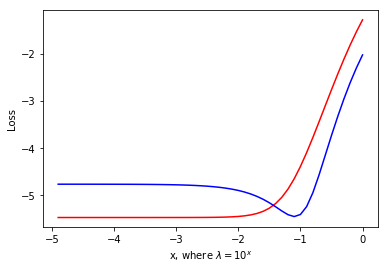

In [125]:
tn = tx.shape[0]
vn = vx.shape[0]
tloss = []
vloss = []
index = -np.arange(0,5,0.1)
for i in index:
    w = ridge_regression(tx,ty,10**i)
    tloss = tloss+[np.sum((np.dot(tx,w)-ty)**2)/tn/2]
    vloss = vloss+[np.sum((np.dot(vx,w)-vy)**2)/vn/2]
print(w)

import matplotlib.pyplot as plt
plt.xlabel("x, where $\lambda = 10^x$")
plt.ylabel("Loss")
plt.plot(index,np.log(tloss),'r')
plt.plot(index,np.log(vloss),'b')
plt.show()

The $\lambda$ that minimizes the validation loss is $10^{-1}$.